## BAPTA Ca2+ spike detection test - results

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import scipy.ndimage as ndi_sp
from scipy.spatial import cKDTree, distance
from skimage.feature import peak_local_max as peak_local_max_np

import cProfile
import os
import glob
import time
import cv2
import h5py
import napari

In [2]:
def distance(coord_pair1, coord_pair2):
    d = np.sqrt((coord_pair1[0]-coord_pair2[0])**2 + (coord_pair1[1]-coord_pair2[1])**2)
    return d

def remove_neighbours(coords_array, d_lim_px=50):
    remove_idxs = []
    for idx1, coord1 in enumerate(coords_array):
        frame1 = coord1[0]
        coordpair1 = coord1[1:]
        for idx2, coord2 in enumerate(coords_array[idx1+1:-1]):
            idx2 = idx2 + idx1 + 1
            #print([idx1, idx2])
            frame2 = coord2[0]
            coordpair2 = coord2[1:]
            if frame1 == frame2:
                d = distance(coordpair1, coordpair2)
                if d < d_lim_px:
                    remove_idxs.append(idx2)
    remove_idxs = np.unique(remove_idxs)
    if np.size(remove_idxs) > 0:
        coords_array = np.delete(coords_array, remove_idxs, axis=0)
    return coords_array

In [3]:
folder = 'example_data_validationruns'

In [11]:
analysisfiles = []
for file in os.listdir(folder):
    if file.endswith('analysiscoords.csv'):
        analysisfiles.append(os.path.join(folder, file))
        
manualfiles = []
for file in os.listdir(folder):
    if file.endswith('manualcoords.csv'):
        manualfiles.append(os.path.join(folder, file))

d_lim = 5  # um
pxs = 0.1  # um/px
d_lim_px = d_lim/pxs
frame_diff_lim = 2

tp_rates = []
events_det_tot = []
de_rates = []
events_ann_tot = []
cf_rates = []
def_rates = []

# load analysis coords
for analysisfile, manualfile in zip(analysisfiles,manualfiles):
    print(analysisfile.split('_')[2].split('\\')[-1])
    
    analysiscoords_raw = np.loadtxt(analysisfile, delimiter=',')
    manualcoords_raw = np.loadtxt(manualfile, delimiter=',')
    
    if np.size(analysiscoords_raw) > 3 and np.size(manualcoords_raw) > 3:
        # remove close-by neighbours to not undercount accuracy/precision - but always compare with the raw instead
        analysiscoords_clean = remove_neighbours(analysiscoords_raw)
        manualcoords_clean = remove_neighbours(manualcoords_raw)
        #analysiscoords = analysiscoords_raw
        #manualcoords = manualcoords_raw
        
        det_events = 0
        det_true = 0
        event_frames = []
        match_frames = []
        # compare all analysiscoords to all manualcoords, to check for ~matches, to calculate accuracy
        for analysiscoord in analysiscoords_clean:
            det_events += 1
            frame_ana = analysiscoord[0]
            event_frames.append(frame_ana)
            coordpair_ana = analysiscoord[1:]
            for manualcoord in manualcoords_raw:
                frame_man = manualcoord[0]
                coordpair_man = manualcoord[1:]
                if np.abs(frame_ana-frame_man) < frame_diff_lim:
                    d = distance(coordpair_ana, coordpair_man)
                    if d < d_lim_px:
                        #print(f'Match, distance: {d:.2f} px')
                        det_true += 1
                        match_frames.append(frame_man)
                        break
        det_event_frames = np.unique(event_frames)
        confirmed_det_event_frames = np.unique(match_frames)
        n_frames = np.ceil(np.max(event_frames)/50)*50
        empty_frames = n_frames - len(det_event_frames)
        correct_frame_rate = (len(confirmed_det_event_frames) + empty_frames) / n_frames

        print(f'Correct frame rate: {correct_frame_rate:.3f}')
        cf_rates.append(correct_frame_rate)
        tp_rate = det_true/det_events
        print(f'True positive detected event rate: {tp_rate}')
        tp_rates.append(tp_rate)
        print(f'Total detected events: {det_events}')
        events_det_tot.append(det_events)

        real_events = 0
        det_real_events = 0
        event_frames = []
        match_frames = []
        # compare all manualcoords to all analysiscoords, to check for ~matches, to calculate precision
        for manualcoord in manualcoords_clean:
            real_events += 1
            frame_man = manualcoord[0]
            event_frames.append(frame_man)
            coordpair_man = manualcoord[1:]
            for analysiscoord in analysiscoords_raw:
                frame_ana = analysiscoord[0]
                coordpair_ana = analysiscoord[1:]
                if np.abs(frame_man-frame_ana) < frame_diff_lim:
                    d = distance(coordpair_man, coordpair_ana)
                    if d < d_lim_px:
                        #print(f'Match, distance: {d:.2f} px')
                        det_real_events += 1
                        match_frames.append(frame_ana)
                        break
        
        real_event_frames = np.unique(event_frames)
        detected_real_event_frames = np.unique(match_frames)
        de_frame_rate = len(detected_real_event_frames)/len(real_event_frames)
        
        de_rate = det_real_events/real_events
        print(f'Detected event rate: {de_rate}')
        de_rates.append(de_rate)
        print(f'Detected event frames rate: {de_frame_rate:.3f}')
        def_rates.append(de_frame_rate)
        print(f'Total annotated events: {real_events}')
        events_ann_tot.append(real_events)
        print('')
    else:
        print('Less than 2 detected or annotated coords.')
        print('')
        
print(f'Total correct frame rate: {np.mean(cf_rates):.3f} +/- {np.std(cf_rates, ddof=1) / np.sqrt(np.size(cf_rates)):.3f}')
print(f'Total detected events frames rate: {np.mean(def_rates):.3f} +/- {np.std(def_rates, ddof=1) / np.sqrt(np.size(def_rates)):.3f}')
print(f'Total true positive rate: {np.mean(tp_rates):.3f} +/- {np.std(tp_rates, ddof=1) / np.sqrt(np.size(tp_rates)):.3f}')
print(f'Total detected event rate: {np.mean(de_rates):.3f} +/- {np.std(de_rates, ddof=1) / np.sqrt(np.size(de_rates)):.3f}')

summary_neurons = {'tp_rate': tp_rates, 'de_rate': de_rates, 'cf_rate': cf_rates, 'def_rate': def_rates, 'dataset': 'neurons'}
summary_neurons_df = pd.DataFrame(data=summary_neurons)
print(summary_neurons_df)

13h27m06s957871us
Correct frame rate: 0.980
True positive detected event rate: 0.9642857142857143
Total detected events: 28
Detected event rate: 0.9032258064516129
Detected event frames rate: 0.714
Total annotated events: 31

Total correct frame rate: 0.980 +/- nan
Total detected events frames rate: 0.714 +/- nan
Total true positive rate: 0.964 +/- nan
Total detected event rate: 0.903 +/- nan
    tp_rate   de_rate  cf_rate  def_rate  dataset
0  0.964286  0.903226     0.98  0.714286  neurons


C:\Users\Jonatan\miniconda3\envs\smartstedanalysis\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Jonatan\miniconda3\envs\smartstedanalysis\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


    tp_rate   de_rate  cf_rate  def_rate  dataset
0  0.964286  0.903226     0.98  0.714286  neurons


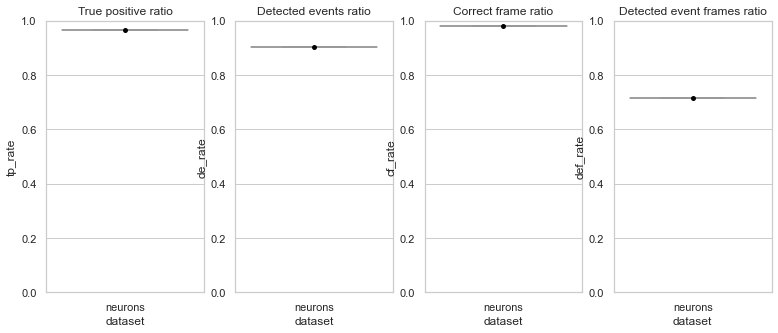

In [12]:
save = False

frames = [summary_neurons_df]
summary_tot = pd.concat(frames)
print(summary_tot)
    
fig1, axs = plt.subplots(1, 4, figsize=(13,5))
sns.set(style='whitegrid')
sns.boxplot(x='dataset', y='tp_rate', data=summary_tot, showfliers=False, ax=axs[0], color="1")
sns.swarmplot(x='dataset', y='tp_rate', data=summary_tot, color="0", ax=axs[0])
axs[0].set_ylim([0,1])
axs[0].set_title('True positive ratio')

sns.set(style='whitegrid')
sns.boxplot(x='dataset', y='de_rate', data=summary_tot, showfliers=False, ax=axs[1], color="1")
sns.swarmplot(x='dataset', y='de_rate', data=summary_tot, color="0", ax=axs[1])
axs[1].set_ylim([0,1])
axs[1].set_title('Detected events ratio')

sns.set(style='whitegrid')
sns.boxplot(x='dataset', y='cf_rate', data=summary_tot, showfliers=False, ax=axs[2], color="1")
sns.swarmplot(x='dataset', y='cf_rate', data=summary_tot, color="0", ax=axs[2])
axs[2].set_ylim([0,1])
axs[2].set_title('Correct frame ratio')

sns.set(style='whitegrid')
sns.boxplot(x='dataset', y='def_rate', data=summary_tot, showfliers=False, ax=axs[3], color="1")
sns.swarmplot(x='dataset', y='def_rate', data=summary_tot, color="0", ax=axs[3])
axs[3].set_ylim([0,1])
axs[3].set_title('Detected event frames ratio')

plt.show()

if save:
    savefolder = 'example_data_validationruns'
    fig1.savefig(os.path.join(savefolder, 'characterization_accuracy-alt.svg'))

In [13]:
print(summary_tot), print('')

print('HeLa')
print(summary_tot['tp_rate'][(summary_tot['dataset']=='neurons')]), print(np.mean(summary_tot['tp_rate'][(summary_tot['dataset']=='neurons')])), print(np.std(summary_tot['tp_rate'][(summary_tot['dataset']=='neurons')])), print('')
print(summary_tot['de_rate'][(summary_tot['dataset']=='neurons')]), print(np.mean(summary_tot['de_rate'][(summary_tot['dataset']=='neurons')])), print(np.std(summary_tot['de_rate'][(summary_tot['dataset']=='neurons')])), print('')

    tp_rate   de_rate  cf_rate  def_rate  dataset
0  0.964286  0.903226     0.98  0.714286  neurons

HeLa
0    0.964286
Name: tp_rate, dtype: float64
0.9642857142857143
0.0

0    0.903226
Name: de_rate, dtype: float64
0.9032258064516129
0.0



(None, None, None, None)